<a href="https://colab.research.google.com/github/aahincapie/DS-Env/blob/master/ForestLosses_CO2000_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instructions**:
- Open your Google Earth Engine account at: [https://code.earthengine.google.com/](https://code.earthengine.google.com/)
- To authorize the access required by Earth Engine, follow these steps:
  1. Open the following URL in a web browser: [https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=Bor4UAEpdIbnPAi-GvvD2L14fQxtWjauqaw9VULu2XQ&tc=8pN9cY7pTa8jiXreiYiooLTWRNENBed_eTxDCmxhdOc&cc=-ado3QqRzNA-nRJ8fznnqekTlSgM3cERTI1ItaliNm8](https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=Bor4UAEpdIbnPAi-GvvD2L14fQxtWjauqaw9VULu2XQ&tc=8pN9cY7pTa8jiXreiYiooLTWRNENBed_eTxDCmxhdOc&cc=-ado3QqRzNA-nRJ8fznnqekTlSgM3cERTI1ItaliNm8)
  2. Follow the provided instructions.

**Read more**:
- Learn about the tree cover change data from the University of Maryland (Hansen): [UMD Hansen Global Forest Change 2022 v1.10](https://developers.google.com/earth-engine/datasets/catalog/UMD_hansen_global_forest_change_2022_v1_10)

- This basic code can be enhanced, adapted, and adjusted based on instructions like those provided in the [Forest Cover Loss Estimation tutorial](https://developers.google.com/earth-engine/tutorials/community/forest-cover-loss-estimation) by Google Earth Engine.

- Explore the accuracy of Hansen data for Colombia in this article: [Sensitivity of the Hansen Data for Colombia](https://link.springer.com/article/10.1007/s10651-023-00571-w) (spoiler: there are regions where they perform better than IDEAM data).

**Note**:
Until 2019, IDEAM was a global leader in deforestation estimation. IDEAM's data is validated in the field by regional environmental authorities (CAR), whereas Hansen's data is not (it doesn't differentiate forest crops, for instance; IDEAM classifies other cover types in addition to forests).

**Sources**:
- [IDEAM GeoViewer and Queries](http://www.ideam.gov.co/web/siac/geovisorconsultas)




In [1]:
!pip install earthengine-api
!pip install geemap
!pip install geopandas
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.6 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11125 sha256=10675fa8c859a2a47634bc8396a444ef6f728cb457e0fa189e354871a1449882
  Stored in directory: /root/.cache/pip/wheels/04/24/fe/140a94a7f1036003ede94579e6b4227f

In [6]:
import ee
import geemap
import matplotlib.pyplot as plt

# Inicie Earth Engine
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=Bor4UAEpdIbnPAi-GvvD2L14fQxtWjauqaw9VULu2XQ&tc=8pN9cY7pTa8jiXreiYiooLTWRNENBed_eTxDCmxhdOc&cc=-ado3QqRzNA-nRJ8fznnqekTlSgM3cERTI1ItaliNm8

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1Adeu5BWLCmYBWB7WSuqv-uvivJzqTW70SKJqdeglGAtbX_f1DIQ08cg1D-s

Successfully saved authorization token.


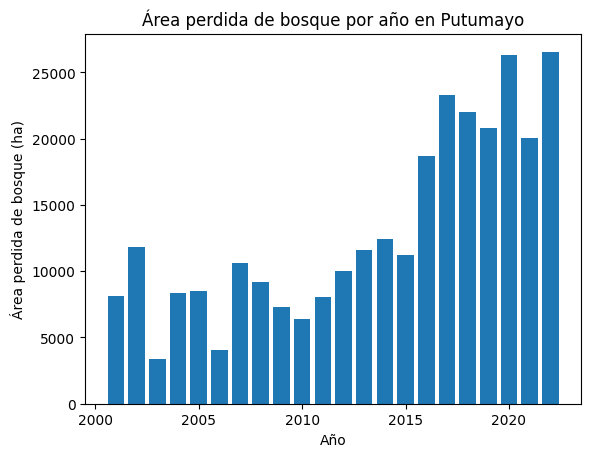

In [7]:
# Escriba el departamento sin acentos
departamento = 'Putumayo'

# Carga de datos Global Forest Change
dataset = ee.Image('UMD/hansen/global_forest_change_2022_v1_10')

# Cargar datos GAUL nivel 2 para Colombia
paises = ee.FeatureCollection('FAO/GAUL/2015/level2')
colombia = paises.filter(ee.Filter.eq('ADM0_NAME', 'Colombia'))
selected = colombia.filter(ee.Filter.eq('ADM1_NAME', departamento))

# Calcular pérdida para cada año (2001 a 2022) y almacenar áreas perdidas
areas_perdidas = []  # Lista para almacenar áreas perdidas

for year in range(1, 23):
    # Seleccionar pixeles de cobertura arbórea perdida
    treeLossYear = dataset.select(['lossyear'])
    lossPixels = treeLossYear.eq(year).selfMask()

    # Applicar criterio de área mínima con connectedPixelCount
    contLoss = lossPixels.connectedPixelCount()
    minLoss = contLoss.gte(6).selfMask()

    # Calcular el área perdida (ha)
    lossArea = minLoss.multiply(ee.Image.pixelArea()).divide(10000)
    lossSize = lossArea.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=selected.geometry(),
        scale=30,
        maxPixels=1e13
    )

    # Almacenar el área perdida por año
    area_perdida = lossSize.get('lossyear')
    areas_perdidas.append(area_perdida.getInfo())

# Graficar pérdida anual
plt.bar(range(2001, 2023), areas_perdidas)
plt.xlabel('Año')
plt.ylabel('Área perdida de bosque (ha)')
plt.title(f'Área perdida de bosque por año en {departamento}')
plt.show()